## Dependencies

In [2]:
#!pip install alphabet-detector
#!pip install ipywidgets
#!pip install cufflinks --upgrade

In [1]:
import pandas as pd
import re # regular expression
import numpy as np

import nltk

import nltk
import numpy as np
from nltk.tokenize import TweetTokenizer

# Generate a word cloud image
import os
from os import path
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from alphabet_detector import AlphabetDetector #used to extract only hashtags written in latin
from IPython.display import clear_output
from collections import defaultdict

In [32]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import clear_output

## Part 1: Prepare data for analysis
**Note:** Run code in this section to extract and save files (these files can be find on github, so no need to run it)

In [6]:
#Raw file that was extracted from the original file (contains dates and hashtag) - i.e. removed columns with tweetid and etc
filename = 'hashtags_date.csv'
df = pd.read_csv(filename, low_memory=False, encoding='utf-8', dtype={ 'text':str})

In [7]:
vocab = set() # list of unique hashtags
tags = list() # all the hashtags

In [8]:
# fill the vocabulary list (all the unique hashtags) and the tags list(i.e. all the hashtags)
for index, row in df.iterrows():
    text = str(row['text']).split(' ')
    text = [w for w in text if w != '']
    vocab.update(text)
    tags.extend(text)

In [9]:
df_vocab = df.copy() #copy the dataframe, new dataframe will store only unique hashtags per day
#this loop will remove repetition of hashtags (done per day)
for index, row in df.iterrows():
    text = set(str(row['text']).split(' '))
    df_vocab.at[index,'text'] = ' '.join(text)

In [11]:
#To calculate TF-IDF for each word
VOCAB_SIZE = len(vocab)
DAYS_COUNT = df.shape[0] # each day is considered to be a document

tknzr = TweetTokenizer(strip_handles=True) #initialize tokenizer

word_index = {w: idx for idx, w in enumerate(list(vocab))} #in this disctionary each words (in the vocab) has a unique id
word_idf = np.zeros(VOCAB_SIZE) #initialise a vector where we store the IDF

#for each occurence of the word we update the word_idf list (e.g. if at some point we get "news",
# we add 1 to the word_idf[index(news)], where index(news) corresponds to a unique ID from word_index
for index, row in df.iterrows():
    words = tknzr.tokenize(str(row['text']))
    indexes = [word_index[str(word)] for word in words if word in vocab]
    word_idf[indexes] += 1.0

# calculate the idf per word 
idf = np.log( DAYS_COUNT / (1 + word_idf).astype(float))


In [12]:
# Functions to CALCULATE the TF and TF-IDF
def tf(word, string_):
    return string_.count(word)/len(string_)

def tf_idf(word, string_):
    return tf(word, string_) * word_idf[word_index[word]]


In [13]:
i = 0
#Calculate TF-IDF for each word (might take some time) and store it in 
for w in vocab:
    i += 1
    clear_output(wait=True)
    TF_IDF[w] = float(tf_idf(w,tags))
    print("Progress: %.2f %%" %((i / VOCAB_SIZE) * 100))

TF_IDF = sorted(TF_IDF.items(), key=lambda value: value[1], reverse=True)

Progress: 100.00 %


In [14]:
#save results to a file
with open('tf_idf_all_hashtags.txt', 'w', encoding='utf-8') as f:
    for item in TF_IDF:
        f.write("%s\n" % str(item))

### Read the file with HASHTAGS : TF-IDF (all)

In [15]:

TF_IDF = defaultdict(float)

# READ THE FILE WITH HASHTAGS and TF-IDF
with open('tf_idf_all_hashtags.txt', 'r', encoding='utf-8') as f:
    for line in f:
        line = (line.split(','))
        frq = float(re.sub(r"[\'()\\n]", "", line[1]))
        TF_IDF[re.sub(r"[-\'()\"#/@;:<>{}`+=~|.!?,]", "", line[0])] = frq
    f.close()
print("Finished")

Finished


In [16]:
# Object that checks the alphabet
ad = AlphabetDetector()

### Create a dictionary with HASHTAGS: TF-IDF (only english)

In [17]:
# THIS code is used to remove all non-latin-written hashtags
TF_IDF_ENG = defaultdict(float)
# first we read all the hashtags 
with open('tf_idf_all_hashtags.txt', 'r', encoding='utf-8') as f:
    for line in f:
        line = (line.split(','))
        tag = re.sub(r"[-\'()\"#/@;:<>{}`+=~|.!?,]", "", line[0])  #remove symbols that are not part of the hashtag
        frq = float(re.sub(r"[\'()\\n]", "", line[1]))
        if(ad.only_alphabet_chars(u''+ tag, "LATIN")): #check for latin characters
            TF_IDF_ENG[tag] = frq
    f.close()
    print("Finished")


Finished


In [13]:
#write the result into the file
with open('tf_idf_eng_hashtags.txt', 'w', encoding='utf-8') as f:
    for k, v in TF_IDF_ENG.items():
        f.write("%s %.2f \n" % (k,v))

## Part 2: TF-IDF

#### Before running it, read the data from files to fill dict TF_IDF and TF_IDF_ENG

(-0.5, 999.5, 807.5, -0.5)

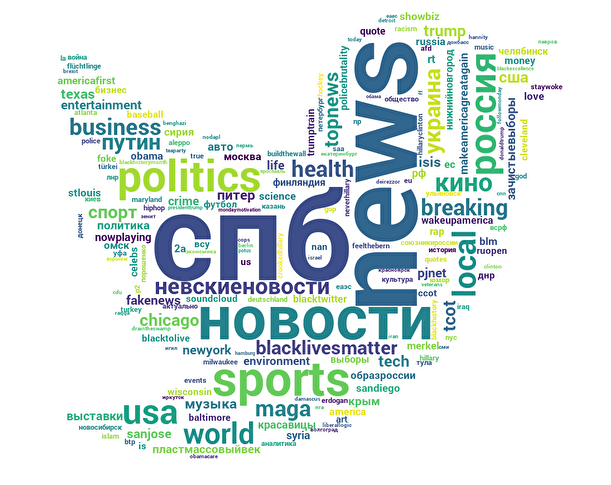

In [40]:
#create a wordcloud
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd() #get a path
twitter_mask = np.array(Image.open(path.join(d, "twitter_mask.png"))) # full path to a mask image
font =  path.join(d, "font.ttf") # font file
font_1 = path.join(d, 'cl.ttf') #font file

#wordcloud
wordcloud = WordCloud(background_color="white", 
                      mask = twitter_mask,
                      width=1800,
                      height=1400,
                      font_path = font_1).generate_from_frequencies(TF_IDF)

# Display the generated image:
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='sinc')
plt.savefig('./full_cloud.png', dpi=200, bbox_inches='tight',transparent=True)
plt.axis("off")

(-0.5, 999.5, 807.5, -0.5)

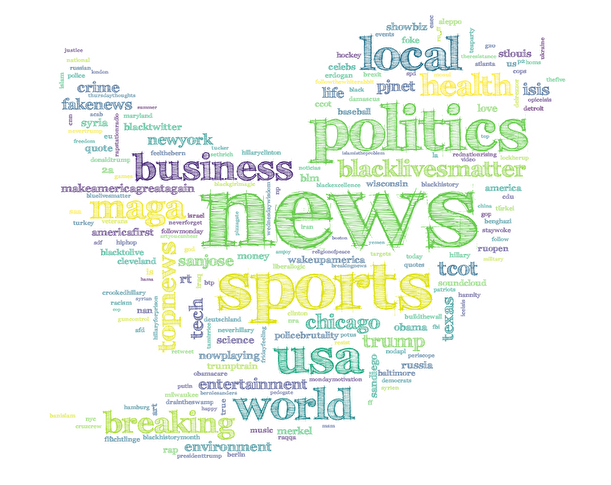

In [41]:
#see previous cell
wordcloud = WordCloud(background_color="white", 
                      mask = twitter_mask,
                      width=1800,
                      height=1400,
                      font_path = font).generate_from_frequencies(TF_IDF_ENG)

# Display the generated image:
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='sinc')
plt.savefig('./eng_cloud.png', dpi=200)
plt.axis("off")

# Part 3: Plot (only for english tweets)

In [ ]:
#read file with dates and hashtags (userid is removed)
filename = 'hashtags_date.csv'
df = pd.read_csv(filename, low_memory=False, encoding='utf-8', dtype={ 'text':str})

In [30]:
ad = AlphabetDetector() # object to check the alphabet of the character

df_filtered = df.copy() #only english tweets (i.e. written in latin)
for index, row in df.iterrows():
    text = str(row['text']).split(' ')
    text = [w for w in text if ad.only_alphabet_chars(u''+ w, "LATIN") and w != '']
    if(len(text) == 0):
        text = ' '
    df_filtered.at[index,'text'] = text

df_filtered['text'].replace(' ', np.nan, inplace=True) #fill empty cells (i.e. when a hashtag is not mentioned during the day)
df_filtered= df_filtered.dropna(subset=['text'])


In [ ]:
# This one saves the occurences of hashtags per day
with open('hashtags_frq.txt', 'w', encoding='utf-8') as f:
    for index, row in df_filtered.iterrows():
        f.write("%s %s \n" %(str(row['date']), str(row['text'].most_common())))

In [31]:
#update the df with frequency values
for index, row in df_filtered.iterrows():
    text = row['text']
    frq = nltk.FreqDist(text)
    df_filtered.at[index, 'text'] = frq

## Part 3: Extract frequencies per day

In [33]:
hashtags = list()
dates = list()
#read all unique hashtags
with open('tf_idf_eng_hashtags.txt', 'r', encoding='utf-8') as f:
    for line in f:
        line = line.split(' ')
        hashtags.append(line[0])
    f.close()

#creates the list of all the dates #thus the frequencies here are not used
with open('hashtags_frq.txt', 'r', encoding='utf-8') as f:
    for line in f:
        line = line.split(' ')
        dates.append(line[0])



In [34]:
df_ = pd.DataFrame(0, columns=hashtags, index=dates) # creates a dataframe, rows are dates and column are unique hashtags
#i.e. it is a large confusion matrix

In [35]:
#for each date we count amount of time each hashtag was mentioned and add this value to the cell that is (DATE, HASHTAG)
for index, row in df_filtered.iterrows():
    for word, count in row['text'].most_common():
        df_.at[row['date'], word]= count

In [36]:
df_['dates'] = pd.to_datetime(df_.index) # here we create a date column and add dates (that are in the index column)
#these dates are converted to the date time format

In [37]:
dg = df_.groupby(pd.Grouper(key='dates', freq='1M')).sum() # groupby all dates by months
dg.index = dg.index.strftime('%b-%y') #change format of the dates to Month-Year

In [26]:
#dp = dg.head(20)

In [38]:
import plotly.plotly as py
import cufflinks as cf
import pandas as pd
import numpy as np
import plotly
plotly.tools.set_credentials_file(username='germans.savcisens', api_key='GlOQOxOlsVzGLFPlvGGt') #used to upload graphs to plotly


In [39]:


#labels = ['news', 'world', 'maga', 'trump', 'blacktwitter', 'trumptrain', 'health' ]
#display 100 hashtags with the highest TF-IDF and load them to the plotly plot
labels = list(TF_IDF_ENG.keys())
dg.iplot(kind='bar', barmode='stack', fill=True, y=labels[0:100],  xTitle='Date', yTitle='Count', colorscale='spectral')

In [43]:
len(TF_IDF_ENG)

55589